In [374]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(14)

In [428]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, roc_auc_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, roc_auc_score, recall_score, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import dalex as dx
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import EnsembleVoteClassifier

In [380]:
houses_df = pd.read_csv('https://github.com/FylypO/DVT---Project/blob/main/HousePriceIndia.csv?raw=true')

## **Functions**

In [381]:
def data_preprocess(df):

    result = df.copy()

    Q1 = np.percentile(result["Price"], 25)
    Q3 = np.percentile(result["Price"], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR        # poniżej outliery
    upper_bound = Q3 + 1.5 * IQR        # powyżej outliery
    lower_bound = max(0, lower_bound)
    threshold1 = lower_bound + (upper_bound - lower_bound) / 3
    threshold2 = lower_bound + (upper_bound - lower_bound) / 3 * 2
    labels = [0,1,2]
    bins = [-float("inf"), threshold1, threshold2, float("inf")]
    result["Price Category"] = pd.cut(result["Price"], bins=bins, labels=labels, include_lowest=True)

    result['Renovated'] = [1 if e > 0 else 0 for e in result['Renovation Year']]

    result = result.drop(columns=['id', 'Date','Renovation Year', 'Price'])
    
    target = np.array(result["Price Category"])

    return result, target

In [382]:
def train_test_splitter(df, fraction):
    data, target = data_preprocess(df)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = fraction, random_state = 14, stratify = target)
    return X_train.drop(columns='Price Category'), X_test.drop(columns='Price Category'), y_train, y_test

In [383]:
def get_pipeline(model):

  normal = ['number of bedrooms', 'number of bathrooms', 'living area', 'grade of the house', 'Lattitude', 'Longitude', 'living_area_renov', 'lot area', 'Area of the house(excluding basement)', 'lot_area_renov']
  numerical = ['number of floors', 'number of views', 'Area of the basement', 'Postal Code', 'condition of the house', 'Built Year', 'Distance from the airport']
  categorical = ['waterfront present', 'Renovated', 'Number of schools nearby']

  #Ustalamy transformacje kolumn
  preprocessor = ColumnTransformer(
    transformers=[
      ('normal', StandardScaler(), normal),
      ('numerical', MinMaxScaler(), numerical),
      ('categorical', OneHotEncoder(), categorical)])

  #Tworzymy pipeline z transformacją i modelem  
  pipeline = Pipeline(steps=[('transformer', preprocessor), ('model', model)])
  return pipeline

In [384]:
def columns(model, dN):
    X_train, X_test, y_train, y_test = train_test_splitter(houses_df, 0.2)
    test = get_pipeline(model)
    test.fit(X_train, y_train)
    exp = dx.Explainer(test, X_train, y_train, verbose=False)
    vi = exp.model_parts(N = dN, B = 20, random_state=14)
    return vi.result

In [435]:
def first_model_tester(df, model, test_param, model_grid, name, dN):

  #Podział na train i test
  X_train, X_test, y_train, y_test = train_test_splitter(df, 0.2)

  #Przekazujemy parametry do modelu
  test_model = model(**test_param)

  test = get_pipeline(test_model)

  #Random search
  random = RandomizedSearchCV(test, model_grid, n_iter=10, cv=5, scoring='recall', n_jobs=-1, random_state=14)
  random.fit(X_train,y_train)

  #Wybieramy najlepsze parametry  
  best = random.best_params_

  #Tworzymy model z najlepszymi parametrami
  parameters = dict()
  for param in best.keys():
      parameters[param.replace("model__","")] = best[param]

  best_model = model(**parameters)
  
  #Zmieniamy model w pipeline
  test = get_pipeline(best_model)

  #Cross validation
  folds = KFold(n_splits=10, shuffle=True, random_state=14)
  cv = cross_val_score(test, X_train, y_train, cv=folds, scoring='accuracy', n_jobs=-1)

  #Sprawdzamy model z najlepszymi parametrami
  test.fit(X_train, y_train)
  y_pred = test.predict(X_test)
  y_pred_prob = test.predict_proba(X_test)

  #Wyniki dla cross validacji
  print(f"średnia dokładności podczas cross validacji dla {str(name)} z najlepszymi parametrami z random searcha: {round(np.mean(cv), 5)}"
    f"\n min: {round(min(cv), 5)} max: {round(max(cv), 5)}")

  #Wyniki dla modelu z najlepszymi parametrami
  print(f"{classification_report(y_test, y_pred)}")
  print(f"roc_ruc_score: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}\n")
  print(f"confusion_matrix:\n {confusion_matrix(y_test, y_pred)}")

  return parameters

## **Logistic Regression**

In [436]:
test_param_lr = {
                "random_state": 14,
                "max_iter": 1000,
                }
                
model_grid_lr = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__penalty': ['l1', 'l2', None],
    'model__class_weight': ['balanced', None],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

In [434]:
param_lr = first_model_tester(houses_df, LogisticRegression, test_param_lr, model_grid_lr, "Logistic Regression", None)

średnia dokładności podczas cross validacji dla Logistic Regression z najlepszymi parametrami z random searcha: nan
 min: nan max: nan
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1062
           1       0.79      0.71      0.75      1382
           2       0.68      0.86      0.76       480

    accuracy                           0.77      2924
   macro avg       0.76      0.79      0.77      2924
weighted avg       0.78      0.77      0.77      2924

roc_ruc_score: 0.9217777697182498

confusion_matrix:
 [[866 194   2]
 [209 976 197]
 [  1  65 414]]


In [388]:
columns(LogisticRegression(**param_lr), None)

,variable,dropout_loss,label
0,grade of the house,0.215011,LogisticRegression
1,Area of the house(excluding basement),0.229099,LogisticRegression
2,living_area_renov,0.259452,LogisticRegression
3,Renovated,0.294502,LogisticRegression
4,number of bedrooms,0.296976,LogisticRegression
5,living area,0.297907,LogisticRegression
6,Number of schools nearby,0.298753,LogisticRegression
7,_full_model_,0.299113,LogisticRegression
8,Distance from the airport,0.299138,LogisticRegression
9,waterfront present,0.299481,LogisticRegression


## **Decision Tree**

In [389]:
test_param_dt = {
    "random_state": 14
}

model_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__splitter': ['best', 'random'],
    'model__max_depth': [None, 2, 4, 6, 8, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced', None]
}

In [390]:
param_dt = first_model_tester(houses_df, DecisionTreeClassifier, test_param_dt, model_grid_dt, "Decision Tree", None)

średnia dokładności podczas cross validacji dla Decision Tree z najlepszymi parametrami z random searcha: 0.72478
 min: 0.70598 max: 0.75278
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1062
           1       0.70      0.75      0.72      1382
           2       0.69      0.70      0.70       480

    accuracy                           0.73      2924
   macro avg       0.73      0.72      0.72      2924
weighted avg       0.73      0.73      0.73      2924

roc_ruc_score: 0.8135673093693824

confusion_matrix:
 [[ 759  303    0]
 [ 199 1035  148]
 [   6  137  337]]


In [392]:
columns(DecisionTreeClassifier(**param_dt), None)

,variable,dropout_loss,label
0,grade of the house,0.170342,DecisionTreeClassifier
1,_baseline_,0.498560,DecisionTreeClassifier
2,Area of the basement,0.600229,DecisionTreeClassifier
3,number of floors,0.600229,DecisionTreeClassifier
4,number of bedrooms,0.600229,DecisionTreeClassifier
5,number of bathrooms,0.600229,DecisionTreeClassifier
6,lot_area_renov,0.600229,DecisionTreeClassifier
7,lot area,0.600229,DecisionTreeClassifier
8,living_area_renov,0.600229,DecisionTreeClassifier
9,living area,0.600229,DecisionTreeClassifier


## **KNN**

In [ ]:
test_param_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': [10, 20, 30, 40],
    'model__p': [1, 2]
}

In [393]:
param_knn = first_model_tester(houses_df, KNeighborsClassifier, test_param_knn, model_grid_knn, "KNN", 1000)

średnia dokładności podczas cross validacji dla KNN z najlepszymi parametrami z random searcha: 0.82122
 min: 0.8118 max: 0.83504
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1062
           1       0.80      0.84      0.82      1382
           2       0.84      0.72      0.78       480

    accuracy                           0.83      2924
   macro avg       0.83      0.81      0.82      2924
weighted avg       0.83      0.83      0.82      2924

roc_ruc_score: 0.9321835057343838

confusion_matrix:
 [[ 909  152    1]
 [ 158 1157   67]
 [   4  129  347]]


In [394]:
columns(KNeighborsClassifier(**param_knn), None)

KeyboardInterrupt: 

## **SVC**

In [ ]:
test_param_svc = {
    "C": [0.1, 1, 10],
    "kernel": ['linear', 'rbf', 'poly'],
    "gamma": ['scale', 'auto'],
    "degree": [2, 3, 4],
    "class_weight": [None, 'balanced'],
    "probability": [True]
}

model_grid_svc = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto'],
    'model__degree': [2, 3, 4],
    'model__class_weight': [None, 'balanced'],
    'model__probability': [True]
}

In [ ]:
param_svc = first_model_tester(houses_df, SVC, test_param_svc, model_grid_svc, "SVC", 1000)

średnia dokładności podczas cross validacji dla SVC z najlepszymi parametrami z random searcha: 0.84088
 min: 0.82891 max: 0.8453
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1062
           1       0.85      0.80      0.83      1382
           2       0.74      0.88      0.80       480

    accuracy                           0.84      2924
   macro avg       0.82      0.85      0.84      2924
weighted avg       0.84      0.84      0.84      2924

roc_ruc_score: 0.957798686801196

confusion_matrix:
 [[ 924  136    2]
 [ 128 1111  143]
 [   2   57  421]]


,variable,dropout_loss,label
0,Area of the house(excluding basement),0.006527,SVC
1,Longitude,0.060046,SVC
2,Built Year,0.061408,SVC
3,grade of the house,0.084731,SVC
4,number of bathrooms,0.093340,SVC
5,living area,0.093457,SVC
6,lot_area_renov,0.094427,SVC
7,number of views,0.100773,SVC
8,waterfront present,0.101079,SVC
9,Renovated,0.101458,SVC


In [ ]:
columns(SVC(**param_svc), None)

## **Random Forest**

In [ ]:
test_param_rf = {
    "random_state": 14,
    "n_jobs": -1
}

model_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False],
    'model__criterion': ["gini", "entropy"]
}

In [396]:
param_rf = first_model_tester(houses_df, RandomForestClassifier, test_param_rf, model_grid_rf, "Random Forest", None)  

średnia dokładności podczas cross validacji dla Random Forest z najlepszymi parametrami z random searcha: 0.86696
 min: 0.86056 max: 0.87778
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1062
           1       0.84      0.91      0.88      1382
           2       0.91      0.78      0.84       480

    accuracy                           0.88      2924
   macro avg       0.89      0.86      0.87      2924
weighted avg       0.88      0.88      0.88      2924

roc_ruc_score: 0.9667972675944719

confusion_matrix:
 [[ 933  129    0]
 [  87 1257   38]
 [   1  105  374]]


In [397]:
columns(RandomForestClassifier(**param_rf), None)

,variable,dropout_loss,label
0,grade of the house,0.007767,RandomForestClassifier
1,living area,0.044589,RandomForestClassifier
2,Area of the house(excluding basement),0.073279,RandomForestClassifier
3,living_area_renov,0.093654,RandomForestClassifier
4,number of views,0.098688,RandomForestClassifier
5,number of bedrooms,0.101675,RandomForestClassifier
6,condition of the house,0.103160,RandomForestClassifier
7,Longitude,0.103727,RandomForestClassifier
8,Renovated,0.103758,RandomForestClassifier
9,waterfront present,0.104136,RandomForestClassifier


## **AdaBoost**

In [ ]:
test_param_ab = {
    "random_state": 14
}

model_grid_ab = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 1.0, 2.0],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

In [ ]:
param_ab = first_model_tester(houses_df, AdaBoostClassifier, test_param_ab, model_grid_ab, "AdaBoost", None)

średnia dokładności podczas cross validacji dla AdaBoost z najlepszymi parametrami z random searcha: 0.65595
 min: 0.63986 max: 0.67436
              precision    recall  f1-score   support

           0       0.87      0.66      0.75      1062
           1       0.60      0.86      0.71      1382
           2       0.23      0.06      0.10       480

    accuracy                           0.66      2924
   macro avg       0.57      0.53      0.52      2924
weighted avg       0.64      0.66      0.62      2924

roc_ruc_score: 0.8433850129041692

confusion_matrix:
 [[ 704  352    6]
 [  99 1192   91]
 [   2  449   29]]


,variable,dropout_loss,label
0,grade of the house,-0.232162,AdaBoostClassifier
1,Area of the basement,-0.232059,AdaBoostClassifier
2,number of floors,-0.232059,AdaBoostClassifier
3,number of bedrooms,-0.232059,AdaBoostClassifier
4,number of bathrooms,-0.232059,AdaBoostClassifier
5,lot_area_renov,-0.232059,AdaBoostClassifier
6,lot area,-0.232059,AdaBoostClassifier
7,living_area_renov,-0.232059,AdaBoostClassifier
8,condition of the house,-0.232059,AdaBoostClassifier
9,number of views,-0.232059,AdaBoostClassifier


In [ ]:
columns(AdaBoostClassifier(**param_ab), None)

## **GradientBoost**

In [ ]:
test_param_gb = {
    "random_state": 14
}

model_grid_gb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

In [398]:
param_gb = first_model_tester(houses_df, GradientBoostingClassifier, test_param_gb, model_grid_gb, "GradientBoost", None)

średnia dokładności podczas cross validacji dla GradientBoost z najlepszymi parametrami z random searcha: 0.87115
 min: 0.86581 max: 0.87692
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1062
           1       0.85      0.90      0.87      1382
           2       0.90      0.78      0.84       480

    accuracy                           0.88      2924
   macro avg       0.88      0.86      0.87      2924
weighted avg       0.88      0.88      0.87      2924

roc_ruc_score: 0.9674432228923747

confusion_matrix:
 [[ 939  123    0]
 [  95 1244   43]
 [   1  103  376]]


In [ ]:
columns(GradientBoostingClassifier(**param_gb), None)

## **XGBoost**

In [458]:
test_param_xgb = {
    "random_state": 14
}

model_grid_xgb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'model__max_depth': [3, 5, 7],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],
    'model__reg_lambda': [0.01, 0.1, 1, 10]
}


In [400]:
param_xgb = first_model_tester(houses_df, XGBClassifier, test_param_xgb, model_grid_xgb, "XGBoost", None)

średnia dokładności podczas cross validacji dla XGBoost z najlepszymi parametrami z random searcha: 0.86063
 min: 0.84602 max: 0.87863
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1062
           1       0.85      0.88      0.86      1382
           2       0.86      0.81      0.84       480

    accuracy                           0.87      2924
   macro avg       0.87      0.86      0.86      2924
weighted avg       0.87      0.87      0.87      2924

roc_ruc_score: 0.9612156387416633

confusion_matrix:
 [[ 933  129    0]
 [ 103 1217   62]
 [   0   90  390]]


In [442]:
columns(XGBClassifier(**param_xgb), None)

,variable,dropout_loss,label
0,Area of the house(excluding basement),0.050086,XGBClassifier
1,grade of the house,0.064180,XGBClassifier
2,living area,0.118661,XGBClassifier
3,number of views,0.128127,XGBClassifier
4,Built Year,0.132582,XGBClassifier
5,Longitude,0.135678,XGBClassifier
6,living_area_renov,0.139429,XGBClassifier
7,Area of the basement,0.140222,XGBClassifier
8,condition of the house,0.140516,XGBClassifier
9,Renovated,0.140857,XGBClassifier


## **Dostrajanie parametrów dla RandomForest i XGBoost**

Po przeanalizowaniu wyników, stwierdzamy, że najlepsze wyniki otrzymujemy używając RandomForestClassifier i XGBCalssifier. Teraz spróbujemy znaleźć dla nich optymalne hiperparametry.

Zauważamy, że nawet mało znaczące kolumny nie wpływają negatywie na wyniki modelu, a nawet nieznacznie pomagają, więc nie ma potrzeby ich usuwania

In [439]:
xgb_drop = ['Area of the house(excluding basement)', 'grade of the house', 'living area', 'number of views', 'Built Year', 'Longitude', 'living_area_renov', 'Area of the basement', 'condition of the house', 'Renovated', 'waterfront present', 'Number of schools nearby']
houses, target = data_preprocess(houses_df)
houses_xgb = houses.drop(columns=xgb_drop)

X_train, X_test, y_train, y_test = train_test_split(houses_xgb, target, test_size=0.2, random_state=14, stratify=target) 

normal = ['number of bedrooms', 'number of bathrooms', 'Lattitude', 'lot area', 'lot_area_renov']

numerical = ['number of floors', 'Postal Code', 'Distance from the airport']

# Ustalamy transformacje kolumn
preprocessor = ColumnTransformer(
    transformers=[
      ('normal', StandardScaler(), normal),
      ('numerical', MinMaxScaler(), numerical)])

# Tworzymy pipeline z transformacją i modelem  
pipeline = Pipeline(steps=[('transformer', preprocessor), ('model', XGBClassifier())])
pipeline.fit(X_train, y_train)

# Prognozowanie na danych testowych przy użyciu modelu z potoku
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)

# Wyniki dla modelu z najlepszymi parametrami
print(f"{classification_report(y_test, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}\n")
print(f"confusion_matrix:\n {confusion_matrix(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1062
           1       0.79      0.83      0.81      1382
           2       0.76      0.68      0.72       480

    accuracy                           0.81      2924
   macro avg       0.81      0.78      0.79      2924
weighted avg       0.81      0.81      0.81      2924

roc_auc_score: 0.9364318534367237

confusion_matrix:
 [[ 897  161    4]
 [ 131 1153   98]
 [   3  153  324]]


In [460]:
def best_param(df, model, test_param, model_grid):
  X_train, X_test, y_train, y_test = train_test_splitter(df, 0.2)
  test_model = model(**test_param)
  test = get_pipeline(test_model)
  grid = GridSearchCV(test, model_grid, cv=3, scoring='recall')
  grid.fit(X_train,y_train)
  best = grid.best_params_
  parameters = dict()
  for param in best.keys():
      parameters[param.replace("model__","")] = best[param]
  best_model = model(**parameters)
  test = get_pipeline(best_model)
  test.fit(X_train, y_train)
  y_pred = test.predict(X_test)
  y_pred_prob = test.predict_proba(X_test)
  print(f"{classification_report(y_test, y_pred)}")
  print(f"roc_ruc_score: {roc_auc_score(y_test, y_pred_prob, multi_class='ovr')}\n")
  print(f"confusion_matrix:\n {confusion_matrix(y_test, y_pred)}")
  return parameters

In [461]:
best_xgb = best_param(houses_df, XGBClassifier, test_param_xgb, model_grid_xgb)

In [ ]:
best_rf = best_param(houses_df, RandomForestClassifier, test_param_rf, model_grid_rf)

InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

## **Voting**

In [437]:
X_train, X_test, y_train, y_test = train_test_splitter(houses_df, 0.2)

normal = ['number of bedrooms', 'number of bathrooms', 'living area', 'grade of the house', 'Lattitude', 'Longitude', 'living_area_renov', 'lot area', 'Area of the house(excluding basement)', 'lot_area_renov']
numerical = ['number of floors', 'number of views', 'Area of the basement', 'Postal Code', 'condition of the house', 'Built Year', 'Distance from the airport']
categorical = ['waterfront present', 'Renovated', 'Number of schools nearby']

preprocessor = ColumnTransformer(
  transformers=[
    ('normal', StandardScaler(), normal),
    ('numerical', MinMaxScaler(), numerical),
    ('categorical', OneHotEncoder(), categorical)])

rf_model = RandomForestClassifier(**param_rf)
gb_model = GradientBoostingClassifier(**param_gb)
xgb_model = XGBClassifier(**param_xgb)

final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf', EnsembleVoteClassifier(clfs=[rf_model, gb_model, xgb_model], voting='soft', weights=[0.3, 0.3, 0.4], fit_base_estimators=True))
])
final_model.fit(X_train, y_train)
y_hat_v = final_model.predict(X_test)
y_hat_prob_v = final_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_hat_v))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1062
           1       0.86      0.90      0.88      1382
           2       0.89      0.82      0.85       480

    accuracy                           0.88      2924
   macro avg       0.88      0.87      0.88      2924
weighted avg       0.88      0.88      0.88      2924



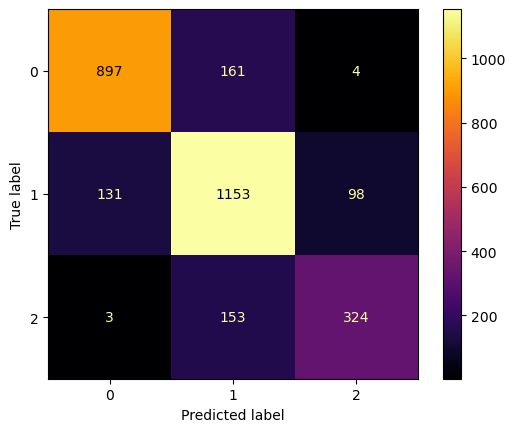

In [438]:
cm = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=cm)
plot.plot(cmap="inferno")

Mimo, iż wyniki recall wydają się lepsze, to patrząc na macierz widać, że klasy są częściej mylone ze sobą